In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.4 MB/s eta 0:00:00


In [2]:
import optuna
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [4]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(60000, 785)

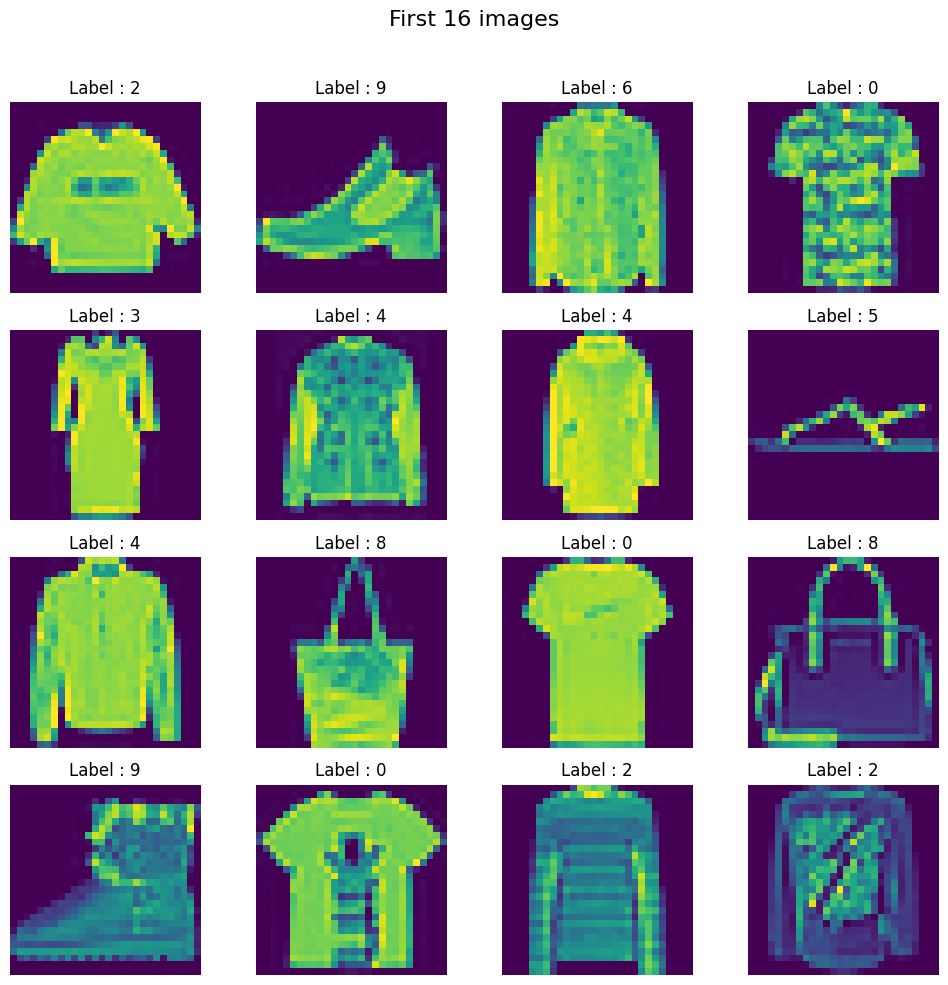

In [7]:
# create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize = (10, 10))
fig.suptitle("First 16 images", fontsize = 16)

# plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label : {df.iloc[i, 0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [8]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train = X_train/255.0
X_test = X_test/255.0

In [11]:
from torchvision import transforms

# Define data augmentations for the training dataset
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [12]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __getitem__(self, index):
        feature, label = self.features[index], self.labels[index]
        if self.transform:
            feature = self.transform(feature.squeeze(0).numpy())  # Apply transform
        return feature, label

    def __len__(self):
        return len(self.features)

In [13]:
# Use augmentations in training data
train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)

In [14]:
# Define the dynamic CNN model class
class DynamicCNN(nn.Module):
    def __init__(self, num_conv_layers, num_filters, kernel_size, num_fc_layers, fc_layer_size, dropout_rate):
        super(DynamicCNN, self).__init__()
        layers = []
        in_channels = 1  # Grayscale images have 1 input channel

        # Convolutional layers
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=kernel_size, padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm2d(num_filters))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = num_filters  # Update input channels for the next layer

        self.features = nn.Sequential(*layers)

        # Fully connected layers
        fc_layers = [nn.Flatten()]
        input_size = num_filters * (28 // (2 ** num_conv_layers)) ** 2
        for _ in range(num_fc_layers):
            fc_layers.append(nn.Linear(input_size, fc_layer_size))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout_rate))
            input_size = fc_layer_size
        fc_layers.append(nn.Linear(input_size, 10))  # Final layer for 10 classes

        self.classifier = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [15]:
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    num_filters = trial.suggest_categorical('num_filters', [16, 32, 64, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    num_fc_layers = trial.suggest_int('num_fc_layers', 1, 3)
    fc_layer_size = trial.suggest_categorical('fc_layer_size', [64, 128, 256])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop'])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 10, 30)

    # Model
    model = DynamicCNN(num_conv_layers, num_filters, kernel_size, num_fc_layers, fc_layer_size, dropout_rate).to(device)

    # Data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
# Run the Optuna study
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=50)  # Run 50 trials

[I 2025-02-10 03:00:58,789] A new study created in memory with name: no-name-364fbe73-2f19-4ef9-ae8c-c9ab43c129bc
<ipython-input-15-aa1058b9f892>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
<ipython-input-15-aa1058b9f892>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
<ipython-input-15-aa1058b9f892>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lea

In [ ]:
# Print the best hyperparameters and accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)